# Outpatient Mortality Prediction
Uses data from the NHANES-I study. The goal is to predict whether patients will die within 10 years of a primary care appointment. The covariates are patient information, lab tests, vital signs, and exam findings. The cost for each features is a monetary cost determined from Medicare fee-for-service data, and the optimization objective is to maximize predictive performance while limiting total dollar cost of the measurements gathered.

Runtime on a laptop with 4-core CPU and 16GB RAM is roughly 2 minutes.

In [16]:
import os, warnings
import coai, coai.knapsack, coai.rfe, coai.plots, coai.cegb
from coai.base import OneDimExplainer
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
from scipy import interpolate
import itertools
from tqdm import tqdm
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from scipy import stats
%matplotlib inline

from sklearn.metrics import r2_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer

coai.knapsack.iterator = coai.rfe.iterator = list

In [17]:
# Check LGB version; versions >= 3 cause problems with CEGB
paper_version = 2.3
lgb_version = float('.'.join(lgb.__version__.split('.')[:2]))
USE_CEGB = True
if lgb_version!=paper_version:
    warnings.warn('Running with a version of LightGBM other than 2.3:\n* Models and results could be slightly different\n* CEGB will not be used in outpatient notebook due\n  to errors in later LGB versions')
    USE_CEGB = False

In [18]:
DATADIR = '../data/nhanes/'

In [19]:
X = pd.read_csv(DATADIR+"X_nhanes_binary.csv").drop(columns="Unnamed: 0")
y = np.load(DATADIR+"y_nhanes_binary.npy")

In [20]:
Xtrain_raw, Xtest_raw, ytrain, ytest = train_test_split(X,y,random_state=100)

In [21]:
imp = Imputer()
ss = StandardScaler()
Xtrain_imp = imp.fit_transform(Xtrain_raw)
Xtest_imp = imp.transform(Xtest_raw)
Xtrain_ss = ss.fit_transform(Xtrain_imp)
Xtest_ss = ss.transform(Xtest_imp)
Xtrain_ss = pd.DataFrame(data=Xtrain_ss,columns=Xtrain_raw.columns)
Xtest_ss = pd.DataFrame(data=Xtest_ss,columns=Xtest_raw.columns)

In [22]:
Xtt, Xtv, ytt, ytv = train_test_split(Xtrain_ss,ytrain,random_state=100)

## Feature Costs

In [23]:
groupnames = np.array(['BUN','Age','Alkaline Phosphatase','CBC w/Diff','Calcium','Cholesterol','Creatinine','Height','Hemoglobin',
             'Physical Activity','CBC Auto','Potassium','Pulse Pressure','Red Blood Cells','Sedimentation Rate','Serum Albumin',
             'Serum Protein','Sex','Sodium','Systolic BP','Total BIlirubin','Uric Acid','Urine Albumin','Urine Glucose','Urinalysis',
             'Weight','SGOT'])

In [24]:
with open('../data/nhanes/feature_groups.txt') as f:
    feature_groups = {l.split(',')[0].strip(): int(l.split(',')[1].strip()) for l in f}

In [25]:
costfile = "feature_costs.txt"
feature_costs = {}
with open(DATADIR+costfile) as f:
    for line in f:
        name, cost = line.split('\t')
        try:
            feature_costs[name.lower()]=float(cost)
        except ValueError:
            feature_costs[name]=np.nan

# Mean impute missing costs
meancost = np.nanmean([v for v in feature_costs.values()])
for k in feature_costs:
    if np.isnan(feature_costs[k]):
        feature_costs[k]=meancost

In [26]:
all_groups = {}
for f in Xtrain_raw.columns:
    for k in feature_groups.keys():
        if k in f.lower():
            all_groups[f]=feature_groups[k]
final_groups = np.array([all_groups[f] for f in Xtrain_raw.columns])

In [27]:
all_costs = {}
for f in Xtrain_raw.columns:
    for k in feature_costs.keys():
        if k in f.lower():
            all_costs[f]=feature_costs[k]
final_costs = np.array([all_costs[f] for f in Xtrain_raw.columns])

In [28]:
# Optional - add tiny pseudocost so we dont have divide-by-zero cost issues
final_costs += 0.001

# Cost-Sensitive Models

In [ ]:
dthresh = np.linspace(0,np.sum(np.unique(final_costs))+1,100)[1:]
bst = lgb.LGBMClassifier()
lin = LogisticRegression()

# CoAI
GRP = coai.knapsack.CoAIOptimizer(bst,OneDimExplainer,scale_ints=1000)
GRP.fit(Xtrain_ss,ytrain,
         feature_costs=final_costs,
         feature_groups=final_groups,
         thresholds=dthresh,cost_criterion=lambda x: True)
GRP.score_models_proba(Xtest_ss,ytest,roc_auc_score)

# Linear CoAI
LinGRP = coai.knapsack.CoAIOptimizer(lin,shap.LinearExplainer,scale_ints=1000)
LinGRP.fit(Xtrain_ss,ytrain,
         feature_costs=final_costs,
         feature_groups=final_groups,
         thresholds=dthresh,cost_criterion=lambda x: True)
LinGRP.score_models_proba(Xtest_ss,ytest,roc_auc_score)

# CEGB
if USE_CEGB:
    CEGB = coai.cegb.CEGBOptimizer(bst,lambdas=[0]+list(np.logspace(-2,5,101)))
    CEGB.fit(Xtrain_ss,ytrain,final_costs)
    CEGB.score_models_proba(Xtest_ss,ytest,roc_auc_score)
    CEGB.model_costs = np.array([GRP.feats_costs(f) for f in CEGB.model_features])

Text(0.5, 1, 'Performance of Cost-Aware Models on Outpatient Data')

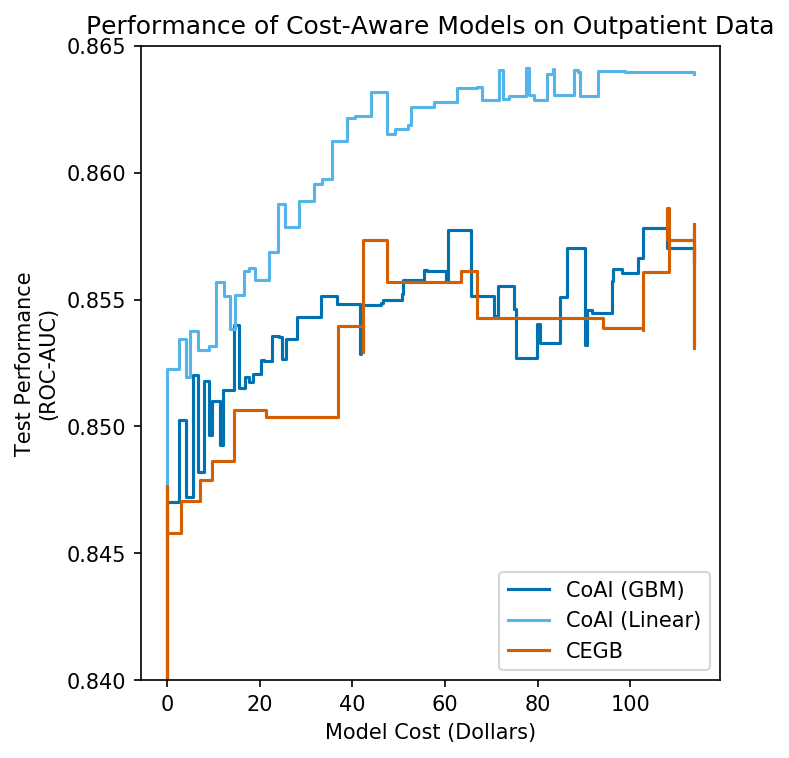

In [30]:
plt.figure(figsize=(5,5),dpi=150)
plt.step(GRP.model_costs,GRP.model_scores,where='post', label='CoAI (GBM)',color='#0072B2')
plt.step(LinGRP.model_costs,LinGRP.model_scores,where='post', label='CoAI (Linear)',color='#56B4E9')
if USE_CEGB: plt.step(CEGB.model_costs,CEGB.model_scores,where='post', label='CEGB',color='#D55E00')
plt.ylim(0.84,0.865)
plt.ylabel("Test Performance\n(ROC-AUC)")
plt.xlabel("Model Cost (Dollars)")
plt.legend()
plt.tight_layout()
plt.title("Performance of Cost-Aware Models on Outpatient Data")